# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

In [1]:
# установка модулей
# !pip install -Uq scikit-learn
# !pip install catboost
# !pip install lightgbm

In [2]:
# импорт библиотеки
import os
import pandas as pd
import numpy as np
import catboost
import lightgbm as lgb
from time import time

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error,make_scorer


from phik.report import plot_correlation_matrix
from phik import report

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment=None

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка данных

In [4]:
autos_df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
autos_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
autos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<b>Вывод</b>

- Данные соответствуют по описанию задачи.
- В датасетах есть  количественные и категориальные признаки.

In [7]:
#количество пропущенных значений
autos_df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
# удалим признаки DateCrawled,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen. Эты признакы неинформативен.
autos_df=autos_df.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'],axis=1)

In [9]:
#Заполним пропушенные значения заглушкой типа 'unknown'
autos_df['VehicleType']=autos_df['VehicleType'].fillna('unknown')
autos_df['Gearbox']=autos_df['Gearbox'].fillna('unknown')
autos_df['Model']=autos_df['Model'].fillna('unknown')
autos_df['FuelType']=autos_df['FuelType'].fillna('unknown')
autos_df['Repaired']=autos_df['Repaired'].fillna('unknown')
 

In [10]:
# Уникальные значения по категориальным значениям
cat_col=autos_df.select_dtypes(include=['object'])
for column in cat_col:
    print(column)
    print(autos_df[column].unique())
    print()

VehicleType
['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']

Gearbox
['manual' 'auto' 'unknown']

Model
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'lo

In [11]:
# удалим неявные дубликаты
autos_df['FuelType'] = autos_df['FuelType'].replace('gasoline','petrol')
autos_df['Model'] = autos_df['Model'].replace('range_rover','rangerover')

<b>Вывод</b>

- Проверена наличие пропущенных значений.
- Убрали неявные дубликатов.
- Удалили неинформативные признаки.
- Заполнили пропушенные значения заглушкой.

In [12]:
# Cтатистический анализ для числовых признаков 
autos_df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


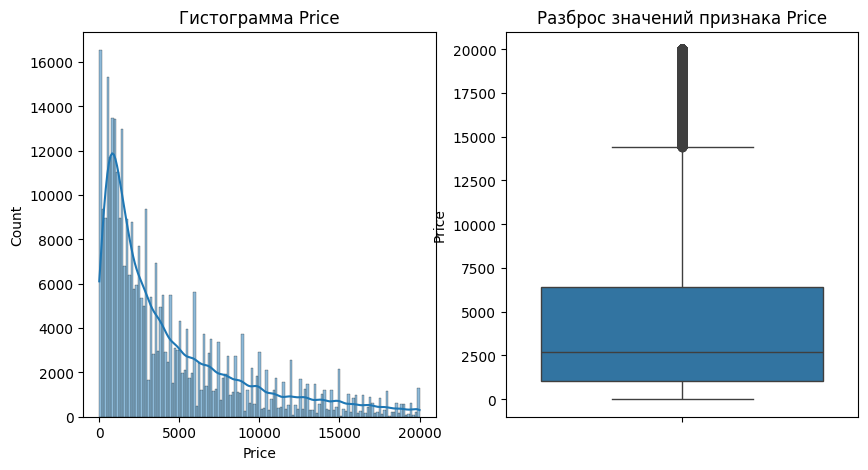

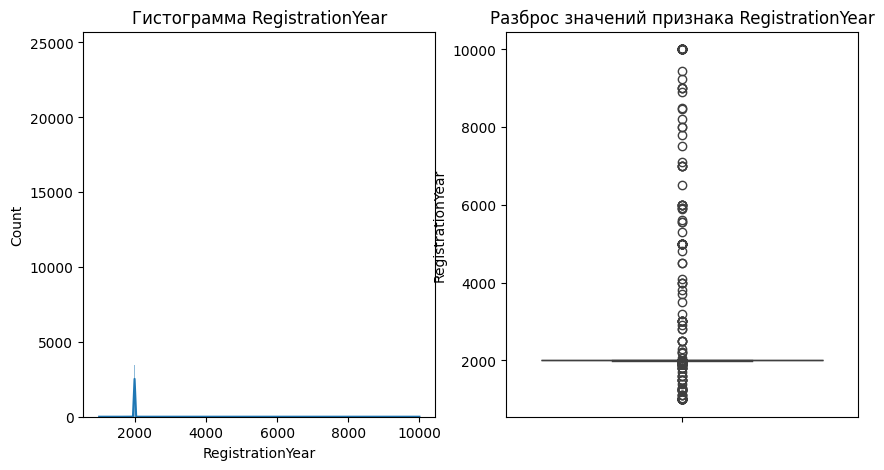

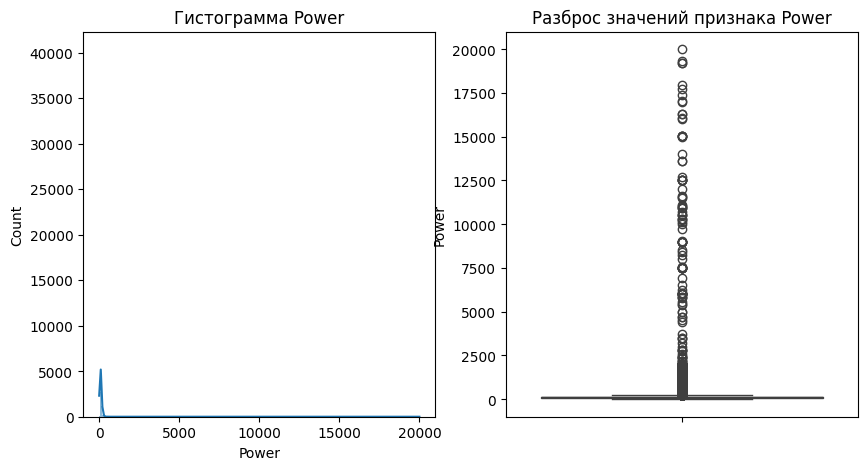

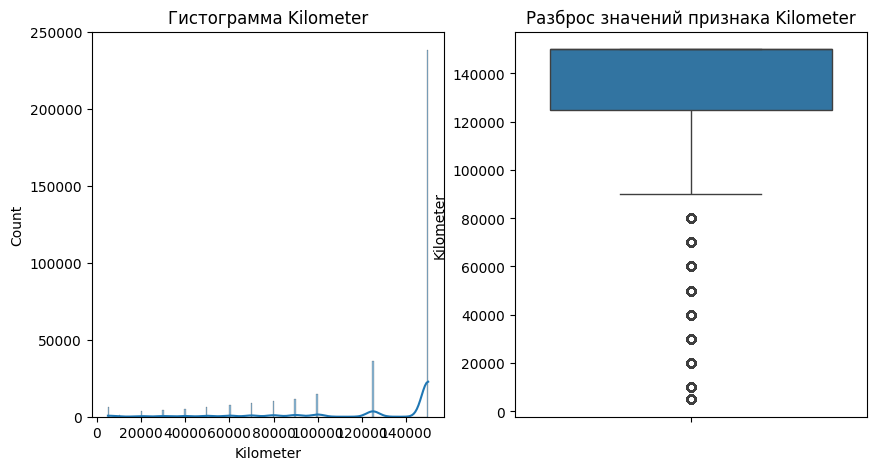

In [13]:
# построим графики по количественным признакам 
# гистограмму частотности распределения и ящик с усами. 
num_col=autos_df.select_dtypes(include=['int64', 'float64'])

for n_col in num_col:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(autos_df[n_col], kde=True)
        plt.title(f'Гистограмма {n_col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=autos_df[n_col])
        plt.title(f'Разброс значений признака {n_col}')
        plt.show()

In [14]:
#удалим значения меньше чем 1000 евро на таргет Price. Потому что врядли можно купить автомобиль
autos_df=autos_df[autos_df['Price']>1000]

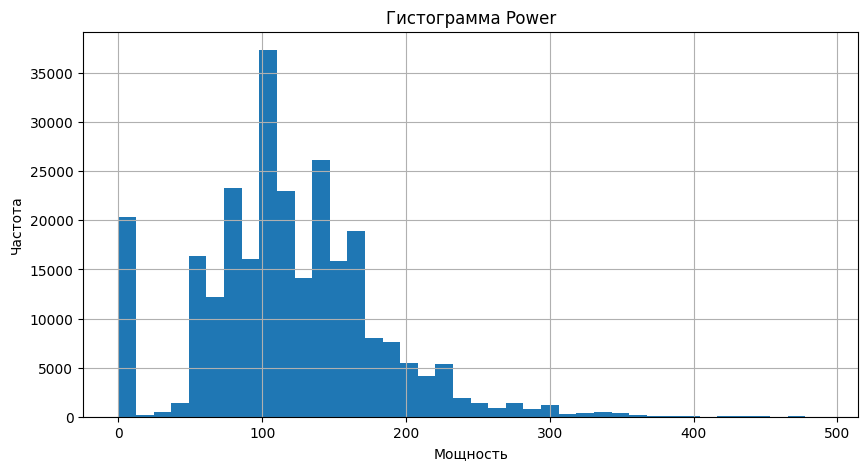

In [15]:
plt.figure(figsize=(10, 5))
autos_df[autos_df['Power']<500]['Power'].hist(bins=40)
plt.xlabel('Мощность')
plt.ylabel('Частота')
plt.title('Гистограмма Power')
plt.show()

In [16]:
#удалим значения признака Power меньше 10 и больше 500.
autos_df=autos_df[(autos_df['Power']>10) & (autos_df['Power']<500)]

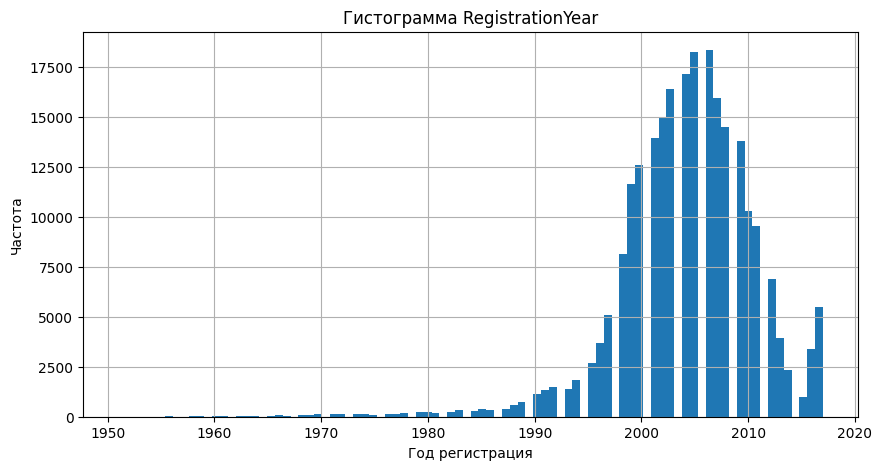

In [17]:
plt.figure(figsize=(10, 5))
autos_df[(autos_df['RegistrationYear']>1950) & (autos_df['RegistrationYear']<=2017)]['RegistrationYear'].hist(bins=90)
plt.xlabel('Год регистрация')
plt.ylabel('Частота')
plt.title('Гистограмма RegistrationYear')
plt.show()

In [18]:
autos_df['RegistrationYear'].unique()

array([2011, 2004, 2001, 2008, 2014, 2005, 2007, 2009, 2002, 2018, 2017,
       1981, 1995, 1991, 1984, 2006, 1998, 2012, 2016, 2010, 2000, 1992,
       1997, 2013, 2003, 1999, 1996, 2015, 1990, 1994, 1989, 1983, 1973,
       1969, 1971, 1987, 1985, 1988, 1980, 1993, 1986, 1976, 1965, 1945,
       1974, 1955, 1982, 1978, 1979, 1972, 1977, 1961, 1975, 1970, 1968,
       1963, 1966, 1958, 1956, 1941, 1960, 1500, 1962, 1929, 1957, 1910,
       1940, 1967, 1949, 1937, 1959, 1953, 2019, 1954, 1234, 1964, 2900,
       6000, 5911, 1932, 1951, 1952, 1950, 5000, 1942, 1935, 1923, 1930,
       9999, 1943, 1938, 1936, 1800, 1928, 1000, 3000, 2800, 1931, 1948,
       4500, 1927, 1933, 1947, 1944], dtype=int64)

In [19]:
#удалим значения признака Год регистрация больше 1980 и меньше 2017. Остальное выбросы и аномалии.
autos_df=autos_df[(autos_df['RegistrationYear']>1980) & (autos_df['RegistrationYear']<=2016)]

<b>Вывод</b>

- Удалили выбросы и аномалии  в столбцах Price,RegistrationYear и Power.


In [20]:
# Функция для корреляционного анализа
def correlation_matrix_phik(df):
    interval_cols = ['Price','Power']
    phik_overview = df.phik_matrix(interval_cols=interval_cols)
    plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12))

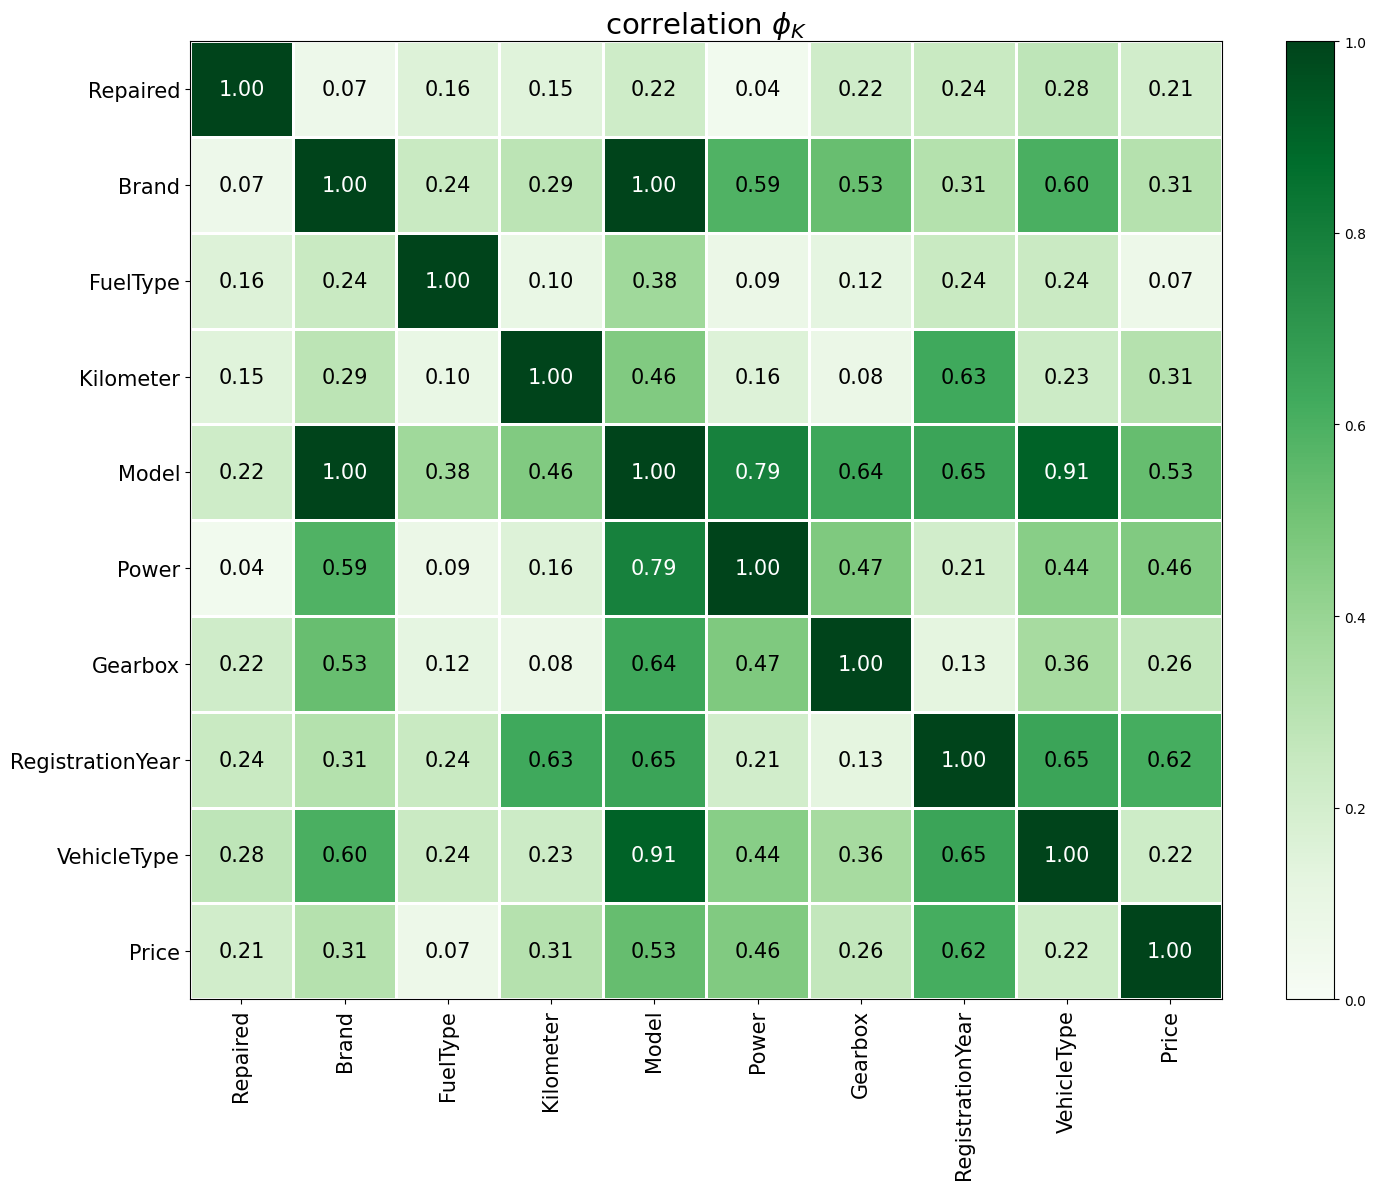

In [21]:
correlation_matrix_phik(autos_df)

In [22]:
print('подсчёт явных дубликатов:',autos_df.duplicated().sum())

подсчёт явных дубликатов: 31046


In [23]:
# удаление явных дубликатов, создание новых индексов
autos_df=autos_df.drop_duplicates().reset_index(drop=True)

<b>Вывод</b>

- По шкале Чеддока очень слабая связ между целевым признакам и остальним признакам.
- Мультиколлинеарность наблюдается между признакам Model и Brand,Power,VehicleType.
- Удалили явные дубликаты.

## Обучение моделей

In [24]:
X=autos_df.drop(['Price'], axis=1)
y=autos_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = TEST_SIZE,  random_state = RANDOM_STATE)

In [25]:
cat_columns = ['VehicleType','Gearbox','Model', 'FuelType','Brand', 'Repaired']
num_columns = ['RegistrationYear','Power','Kilometer']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


### LinearRegression

In [26]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, cat_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
param_grid_lr = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()]
        
    }]


randomized_search_lr = RandomizedSearchCV(
    pipe_final_lr, 
    param_grid_lr, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', (randomized_search_lr.best_score_)*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                 

In [27]:
#замеряем время обучения
start = time()
    
model_lr=randomized_search_lr.best_estimator_
best_lr = model_lr.fit(X_train, y_train)

end = time()
lr_model_time = end-start

print(f'Время обучения модели LinearRegression: {lr_model_time:.1f}s')

Время обучения модели LinearRegression: 10.8s


In [28]:
#замеряем время предсказания
start = time()
    
y_pred = best_lr.predict(X_train)
end = time()
lr_model_predict_time = end-start
print(f'Время предсказания модели LinearRegression: {lr_model_predict_time:.1f}s')


Время предсказания модели LinearRegression: 1.3s


### Catboost

In [29]:
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, cat_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final_cb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', catboost.CatBoostRegressor(random_state=RANDOM_STATE))
])
param_grid_cb = [
    # словарь для модели CatBoostRegressor()
    {
        'models': [catboost.CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10],
        'models__iterations': [100, 500],
    }]

randomized_search_cb = RandomizedSearchCV(
    pipe_final_cb, 
    param_grid_cb, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_cb.fit(X_train, y_train)



Learning rate set to 0.159298
0:	learn: 4100.8323791	total: 240ms	remaining: 1m 59s
1:	learn: 3689.8026593	total: 331ms	remaining: 1m 22s
2:	learn: 3358.3573180	total: 432ms	remaining: 1m 11s
3:	learn: 3082.2096650	total: 509ms	remaining: 1m 3s
4:	learn: 2862.0481220	total: 586ms	remaining: 58s
5:	learn: 2681.6023497	total: 653ms	remaining: 53.8s
6:	learn: 2543.9859255	total: 736ms	remaining: 51.9s
7:	learn: 2433.0267809	total: 803ms	remaining: 49.4s
8:	learn: 2336.9002416	total: 878ms	remaining: 47.9s
9:	learn: 2258.8525458	total: 1.04s	remaining: 50.8s
10:	learn: 2194.2857562	total: 1.16s	remaining: 51.7s
11:	learn: 2149.2804339	total: 1.25s	remaining: 50.8s
12:	learn: 2110.8601719	total: 1.33s	remaining: 49.7s
13:	learn: 2078.1425152	total: 1.4s	remaining: 48.5s
14:	learn: 2037.8288627	total: 1.47s	remaining: 47.4s
15:	learn: 2003.7913006	total: 1.55s	remaining: 46.8s
16:	learn: 1982.3608687	total: 1.61s	remaining: 45.8s
17:	learn: 1963.6712096	total: 1.68s	remaining: 44.9s
18:	lear

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan)),
                                                                                               ('simpleImputer_after_ord',
                                                                                                SimpleImputer(strategy='most_fre...
                                                                               StandardScaler(),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer'])])),
                                             ('models',
                                              <catboost.core.CatBoostRegressor object at 0x00000264000AC190>)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostRegressor object at 0x00000264000AE0D0>],
                                         'models__iterations': [100, 500],
                                         'models__max_depth': [5, 10]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [30]:
print('Лучшая модель и её параметры:\n\n', randomized_search_cb.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                     

In [31]:
print ('Метрика лучшей модели на тренировочной выборке:', (randomized_search_cb.best_score_)*-1)


Метрика лучшей модели на тренировочной выборке: 1632.779869956661


In [32]:
#замеряем время обучения
start = time()
    
model_cb=randomized_search_cb.best_estimator_
best_cb = model_cb.fit(X_train, y_train)

end = time()
cb_model_time = end-start

print(f'Время обучения модели CatBoostRegressor: {cb_model_time:.1f}s')

Learning rate set to 0.159298
0:	learn: 4100.8323791	total: 78.3ms	remaining: 39.1s
1:	learn: 3689.8026593	total: 145ms	remaining: 36.2s
2:	learn: 3358.3573180	total: 217ms	remaining: 35.9s
3:	learn: 3082.2096650	total: 281ms	remaining: 34.8s
4:	learn: 2862.0481220	total: 345ms	remaining: 34.2s
5:	learn: 2681.6023497	total: 412ms	remaining: 33.9s
6:	learn: 2543.9859255	total: 480ms	remaining: 33.8s
7:	learn: 2433.0267809	total: 544ms	remaining: 33.5s
8:	learn: 2336.9002416	total: 610ms	remaining: 33.3s
9:	learn: 2258.8525458	total: 675ms	remaining: 33.1s
10:	learn: 2194.2857562	total: 744ms	remaining: 33.1s
11:	learn: 2149.2804339	total: 813ms	remaining: 33s
12:	learn: 2110.8601719	total: 882ms	remaining: 33s
13:	learn: 2078.1425152	total: 948ms	remaining: 32.9s
14:	learn: 2037.8288627	total: 1.05s	remaining: 34s
15:	learn: 2003.7913006	total: 1.13s	remaining: 34.2s
16:	learn: 1982.3608687	total: 1.2s	remaining: 34.1s
17:	learn: 1963.6712096	total: 1.27s	remaining: 34s
18:	learn: 1946.

In [33]:
#замеряем время предсказания
start = time()
    
y_pred = best_cb.predict(X_train)
end = time()
cb_model_predict_time = end-start
print(f'Время предсказания модели CatBoostRegressor: {cb_model_predict_time:.1f}s')


Время предсказания модели CatBoostRegressor: 1.9s


### LightGBM

In [34]:
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, cat_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final_lgb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', lgb.LGBMRegressor(random_state=RANDOM_STATE))
])
param_grid_lgb = [
    # словарь для модели lgb.LGBMRegressor()
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [8, 15],
        'models__n_estimators': [500,1000],
    }]

randomized_search_lgb = RandomizedSearchCV(
    pipe_final_lgb, 
    param_grid_lgb, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lgb.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_lgb.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', (randomized_search_lgb.best_score_)*-1)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                     

In [35]:
#замеряем время обучения
start = time()
    
model_lgb=randomized_search_lgb.best_estimator_
best_lgb = model_lgb.fit(X_train, y_train)

end = time()
lgb_model_time = end-start

print(f'Время обучения модели LGBMRegressor: {lgb_model_time:.1f}s')

Время обучения модели LGBMRegressor: 7.0s


In [36]:
#замеряем время предсказания
start = time()
    
y_pred = best_lgb.predict(X_train)

end = time()
lgb_model_predict_time = end-start
print(f'Время предсказания модели LGBMRegressor: {lgb_model_predict_time:.1f}s')

Время предсказания модели LGBMRegressor: 5.4s


In [37]:
randomized_search_lgb.best_params_

{'models__n_estimators': 1000,
 'models__max_depth': 15,
 'models': LGBMRegressor(random_state=42)}

<b>Вывод</b>

- Критерий успеха выполнено.
- Лучшая модел LGBMRegressor с параметрами n_estimators= 1000, max_depth=15 и метрика на тренировке rmse_score=1658.


## Анализ моделей

**LinearRegression**

In [38]:
print(f'Время обучения: {lr_model_time:.1f}s')
print(f'Время предсказания: {lr_model_predict_time:.1f}s')

Время обучения: 10.8s
Время предсказания: 1.3s


**CatBoostRegressor**

In [39]:
print(f'Время обучения: {cb_model_time:.1f}s')
print(f'Время предсказания: {cb_model_predict_time:.1f}s')

Время обучения: 35.3s
Время предсказания: 1.9s


**LGBMRegressor**

In [40]:
print(f'Время обучения: {lgb_model_time:.1f}s')
print(f'Время предсказания: {lgb_model_predict_time:.1f}s')

Время обучения: 7.0s
Время предсказания: 5.4s


In [41]:
#Качество модели на тестовой выборке
y_predt = best_lgb.predict(X_test)
rmse_lgb_test=root_mean_squared_error(y_test, y_predt)
print(f'LGBMRegressor метрика RMSE : {rmse_lgb_test:.1f}')

LGBMRegressor метрика RMSE : 1615.3


In [42]:
# Константной модели DummyRegressor
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, cat_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final_dummy = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DummyRegressor(strategy="mean"))])

pipe_final_dummy.fit(X_train,y_train)
y_pred_dummy=pipe_final_dummy.predict(X_test)
rmse_dummy_test=root_mean_squared_error(y_test, y_pred_dummy)
print(f'DummyRegressor метрика RMSE : {rmse_dummy_test:.1f}')



DummyRegressor метрика RMSE : 4610.1


<b>Вывод</b>

- По время обучения и по качество на тренировочной выборке лучший результат показал LGBMRegressor.
- Качество на тестовой выборке лучшая модел LGBMRegressor с параметрами n_estimators= 1000, max_depth=15 и метрика на тесте rmse_score=1666 .
- Результат тестирования нашей модели на тестовой выборке был многократно лучше, чем результат константной модели.


## Общий вывод


- Рекомендую использовать для определения стоимости автомобиля  модель LGBMRegressor с параметрамы n_estimators= 1000, max_depth=15 .
- Разработали модель машинного обучения, которая определяет стоимости автомобиля.

- Провели предобработку данных: удалили неинформативные столбцы, удалили явные дубликаты, заполнили пропущенные значения,удалили выбросы и аномалии.

- Для поиска лучшего моделя использовали пайплан с гиперпараметрами модели LinearRegression() и два бустинга LGBMRegressor, CatBoostregressor и поиска лучшего параметра RandomizedSearchCV.

- Лучшая модель  LGBMRegressor с параметрами n_estimators= 1000, max_depth=15 и метрика на тесте rmse_score=1666 .

- Худшая модель оказалось LinearRegression().

- По время обучения и по метрика rmse_score на тренировочной выборке лучшая модель LGBMRegressor.



<div class="alert alert-block alert-danger">
<h2> Теория <a class="tocSkip"></h2>

    


По этому блоку будет несколько важных замечаний:
1. Все модели этого блока оцениваются на тестовой выборке - это преждевременное решение, так как оценка на тестовой выборке - это финальное тестирование для лучшей модели, которая была отобрана в ходе промежуточного тестирования. Эта концепция находит своё отражение в условиях эксплуатации модели в реальной среде: в промышленной эксплуатации не работает несколько моделей одновременно - в промышленную эксплуатацию запускают только одну модель, которая была выбрана из нескольких в ходе промежуточной оценки. Так же и здесь - тестовая выборка имитирует поток реальных данных, и с этим потоком должна работать только одна модель. 


2. Лучшая модель должна быть выбрана по двум критериям - метрика `RMSE` и время работы модели. Далее сценарий работы с моделями в этом блоке зависит от выбранной стратегии валидации и оптимизации гиперпараметров:
- для оптимизации гиперпараметров и промежуточной оценки моделей была выделена валидационная выборка;
- для оптимизации гиперпараметров и промежуточной оценки моделей проводится кросс-валидация.
    
    В первом случае метрика промежуточной оценки модели - это метрика `RMSE` на валидационной выборке, полученная от использования на `valid` лучшей модели, а время - это время обучения модели с лучшими гиперпарметрами на `train` и время совершения ею предсказаний на `valid`.
    
    Во втором случае метрика промежуточной оценким модели - это метрика `RMSE` с кросс-валидации: в случае использования `cross_val_score` - это среднее из массива метрик (длина соответствует количеству фолдов для кросс-валидации), который возвращает инструмент, в случае использования `GridSearchCV` или `RandomizedSearchCV` - это метрика из атрибута `best_score_`. Временем работы лучшей модели может быть время обучения на `train` и время предсказания на `train` выборке (только время, метрика `RMSE` на тренировочной выборке не нужна).
    
    Тут часто студенты делают ошибку, принимая в качестве метрики времени время работы лучшей модели, а время оптимизации гиперпараметров в целом (то есть время выполнения всей ячейки кода цикла с `cross_val_score` или ячейки с `GridSearchCV`) - это некорректный подход: на практике модель не будет каждый раз переобучаться и выполнять оптимизацию гиперпараметров перед очередным предсказанием - сначала будет найдена лучшая модель, а она уже будет использоваться для обучения и предсказаний. Поэтому и в этом случае сначала определяется лучшая модель, а уже потом замеряется время её работы: кросс-валидации как альтернатива времени обучения и предсказания (потому что по сути кросс-валидация объединяет в себе обучение и предсказание) или время обучения и предсказания на `train`.
    
    Независимо от выбранной стратегии кросс-валидации алгоритм работы выглядит как:
- оптимизация гиперпараметров и поиск лучшей модели;
- оценка метрики `RMSE`;
- оценка времени работы лучшей модели: на валидационной выборке (если она выделялась) или на кросс-валидации/тренировочной выборке (если проводилась кросс-валидация).
    
Концепт для `valid`:
    
    for ... in ...:
    
        #код для поиска лучшей модели
    
    model = ... #код для инициализации лучшей модели с оптимальными гиперпараметрами
    
    model.fit(X_train, Y_train) #замеряем время обучения
    
    pred = model.predict(X_valid) #замеряем время предсказания
    
    RMSE = (Y_valid, pred) #замеряем RMSE на valid
    
Концепт для кросс-валидации:
    
    model = #инициализируем модель
    gs = GridSearchCV(...) #настраиваем поиск по сетке
    
    gs.fit(...) #находим лучшую модель
    
    gs.best_score_ #замеряем RMSE на  кросс-валидации
    
    model = gs.best_estimator_ #получаем лучшую модель из best_estimator
    model = #YourModel(random_state = 42, **gs.best_params) #альтернативный способ получения лучшей модели
    
    model.fit(X_train, Y_train) #замеряем время обучения
    model.predict(X_train) #замеряем время предсказания
    
    
   По итогу нужно будет провести сравнительную характеристику моделей по критериям метрики `RMSE` и времени работы моделей и выбрать лучшую - именно эта лучшая модель должна будет оцениваться на тестовой выборке.
    
   Обрати также внимание, что при создании таблицы нельзя использовать вручную введённые значения - они потеряют актуальность при любом изменении в данных, их обработке или в моделях. Значения метрик лучше помещать в переменные и использовать их для создания таблиц. Для сохранения в переменные времени работы моделей можно использовать модуль `time`:
    
    from time import time
    
    start = time()
    
    #код модели
    
    end = time()
    
    model_time = (end-start)/60 #перевожу в минуты, так как по умолчанию секунды
    
 Альтернативный подход - использование `cv_results_` после обучения `GridSearchCV` в качестве источика метрик (особенно удобно в случае рассмотрения нескольких моделей в пределах одного `Pipeline`). В таком случае можно выполнить группировку по столбцу с названием модели (предварительно извлечь его можно с помощью строкового метода `split()`), найти индексы строк с минимальным значением метрики, и уже из этих строк извлечь время обучения (`mean_fit_time`) и время предсказания (`mean_score_time`).
    
3. Итоговый вывод нужно поправить.